# 👾 PixelCNN using Tensorflow distributions

In this notebook, we'll walk through the steps required to train your own PixelCNN on the fashion MNIST dataset using Tensorflow distributions

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the PixelCNN](#build)
3. [Train the PixelCNN](#train)
4. [Generate images](#generate)

In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from utils.image import display

## 0. Parameters <a name="parameters"></a>

In [15]:
IMAGE_SIZE = 32
N_COMPONENTS = 5
EPOCHS = 10
BATCH_SIZE = 128

## 1. Prepare the data <a name="prepare"></a>

In [18]:
# Load the data
(x_train, _), (_, _) = keras.datasets.fashion_mnist.load_data()

In [19]:
# Preprocess the data

def preprocess(imgs):
    imgs = np.expand_dims(imgs, -1)
    imgs = tf.image.resize(imgs, (IMAGE_SIZE,IMAGE_SIZE)).numpy()
    return imgs

input_data = preprocess(x_train)

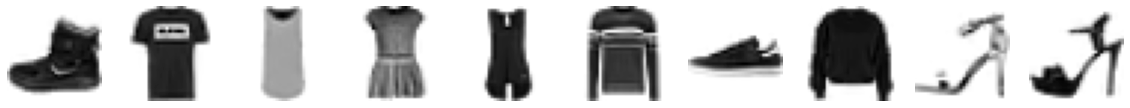

In [20]:
# Show some items of clothing from the training set
display(input_data)

## 2. Build the PixelCNN <a name="build"></a>

In [21]:
# Define a Pixel CNN network
dist = tfp.distributions.PixelCNN(
    image_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    num_resnet=1,
    num_hierarchies=2,
    num_filters=32,
    num_logistic_mix=N_COMPONENTS,
    dropout_p=.3,
)

# Define the model input
image_input = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

# Define the log likelihood for the loss fn
log_prob = dist.log_prob(image_input)

# Define the model
model = keras.Model(inputs=image_input, outputs=log_prob)
model.add_loss(-tf.reduce_mean(log_prob))

## 3. Train the PixelCNN <a name="train"></a>

In [8]:
# Compile and train the model
model.compile(
    optimizer=keras.optimizers.Adam(.001),
    )

In [9]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")

class ImageGenerator(keras.callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img
  
    def generate(self):
        return dist.sample(self.num_img).numpy()

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate()
        display(generated_images, save_to = "./output/generated_img_%03d.png" % (epoch))
        
img_generator_callback = ImageGenerator(num_img=10)

In [12]:
model.fit(input_data
        , batch_size=BATCH_SIZE
        , epochs=EPOCHS
        , verbose=True
        , callbacks=[tensorboard_callback, img_generator_callback]
         )

Layer _PixelCNNNetwork has arguments ['self', 'dropout_p', 'num_resnet', 'num_hierarchies', 'num_filters', 'num_logistic_mix', 'receptive_field_dims', 'resnet_activation', 'use_weight_norm', 'use_data_init']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/10


KeyboardInterrupt: 

## 4. Generate images <a name="generate"></a>

In [77]:
generated_images = img_generator_callback.generate()

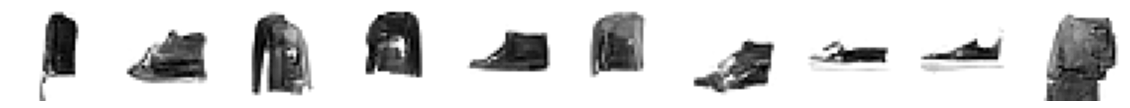

In [79]:
display(generated_images)